In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from lsst.sims.utils import hpid2RaDec, galacticFromEquatorial
import healpy as hp
import pandas as pd
from lsst.sims.maf.maps import TrilegalDensityMap
from lsst.sims.utils import _hpid2RaDec

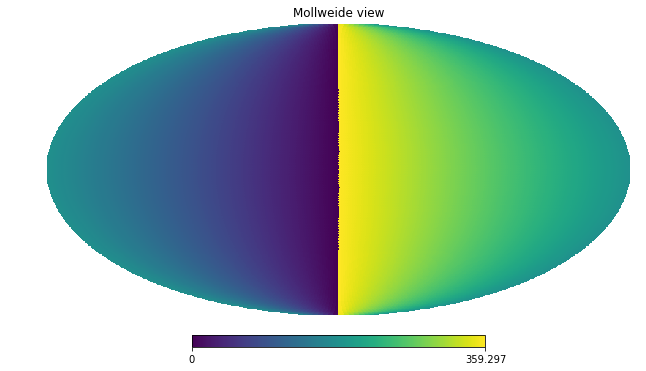

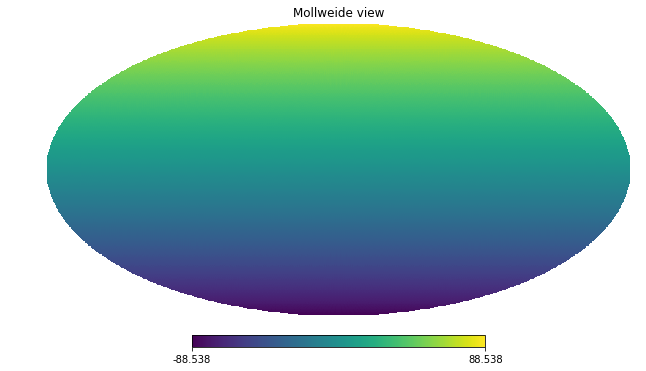

In [2]:
# Set up RA, dec maps
nside = 64
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
hp.mollview(ra)
hp.mollview(dec)

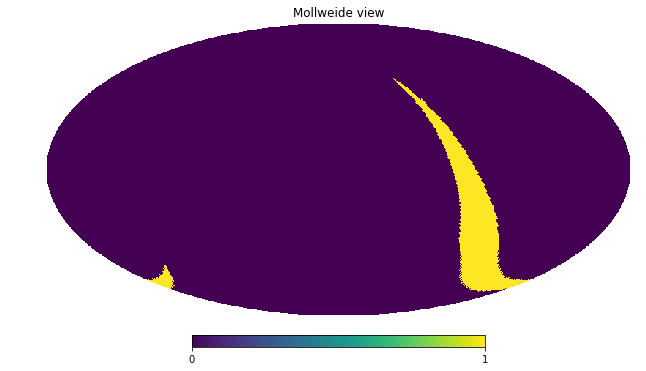

In [3]:
# Let's define some regions!
g_long, g_lat = galacticFromEquatorial(ra, dec)

#diamond = np.where(((g_long < 90) | (g_long > 270)) & (np.abs(g_lat) < 10))
lat_limit = 10 - 10.*g_long/90.
diamond_map = np.zeros(hp.nside2npix(nside), dtype=float)
for i,g in enumerate(g_long):
    if (g_long[i] < 90) & (np.abs(g_lat[i]) <= lat_limit[i]):
        diamond_map[i] = 1

lat_limit = 10 - 10.*(-g_long+360)/90.
for i,g in enumerate(g_long):
    if (g_long[i] > 270) & (np.abs(g_lat[i]) <= lat_limit[i]):
        diamond_map[i] = 1

hp.mollview(diamond_map)
#diamond_map[diamond] = 1

diamond = np.where(diamond_map == 1)[0]

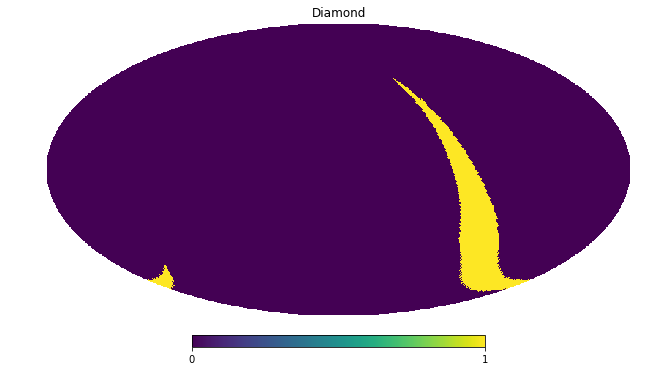

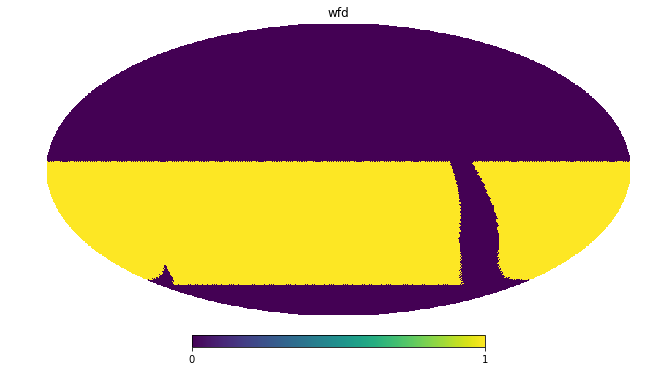

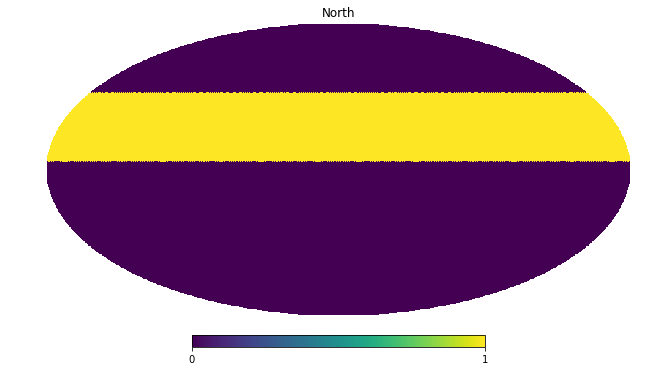

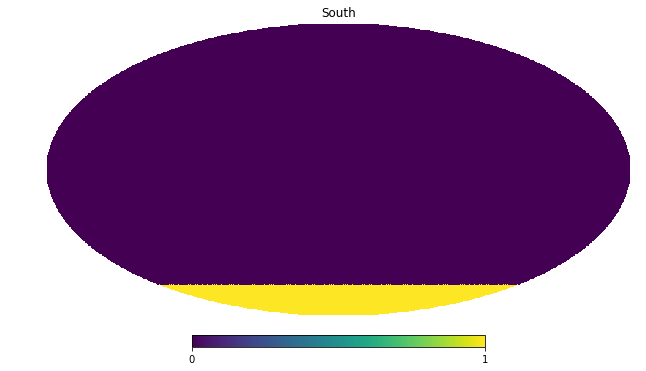

In [4]:
wfd = np.where((dec > -62.5) & (dec < 3.6))
wfd_map = np.zeros(hp.nside2npix(nside), dtype=float)
wfd_map[wfd] = 1
wfd_map[diamond] = 0
hp.mollview(diamond_map, title='Diamond')
hp.mollview(wfd_map, title='wfd')

north = np.where((dec < 40) & (dec > -20))
north_map = np.zeros(hp.nside2npix(nside), dtype=float)
north_map[north] = 1
north_map[wfd] = 0
hp.mollview(north_map, title='North')

south = np.where(dec < -62)
south_map = np.zeros(hp.nside2npix(nside), dtype=float)
south_map[south] = 1
south_map[wfd] = 0
hp.mollview(south_map, title='South')

In [5]:
def tri_rebin(filtername='r', nside=64):
    """Load up the trilegal map and rebin the sucker"""
    maf_map = TrilegalDensityMap(filtername=filtername, nside=nside)
    maf_map._readMap()
    result = maf_map.starMap*0
    indx = np.arange(hp.nside2npix(nside))
    ra, dec = _hpid2RaDec(nside, indx)
    
    sp = {}
    sp['ra'] = ra
    sp['dec'] = dec
    sp = maf_map.run(sp)
    result = sp['starLumFunc_%s' % filtername]
    return result, sp['starMapBins_%s' % filtername]
    

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


billions of stars
   rmag   diamond       wfd     north     south        sum
0  27.6  6.630656  2.755734  1.057123  1.540422  11.983935
1  27.4  6.474981  2.692181  1.029136  1.493440  11.689739
2  27.0  5.870361  2.438236  0.921057  1.322439  10.552094
3  26.0  4.511662  1.839451  0.686047  0.974430   8.011589
4  26.2  4.767512  1.953417  0.728985  1.038568   8.488482
5  24.6  2.917900  1.162262  0.440286  0.574423   5.094871
6  24.4  2.717982  1.085152  0.412449  0.526142   4.741725
7  24.0  2.335346  0.944018  0.360932  0.437591   4.077887
billions of stars
   zmag   diamond       wfd     north     south        sum
0  27.6  6.625120  2.752192  1.055468  1.539589  11.972369
1  27.4  6.624595  2.751611  1.055320  1.539474  11.971000
2  27.0  6.619537  2.745171  1.053681  1.538355  11.956744
3  26.0  6.595971  2.599391  1.026764  1.308310  11.530436
4  26.2  6.603669  2.643617  1.034028  1.377235  11.658549
5  24.6  6.038623  2.059644  0.899361  0.869566   9.867193
6  24.4  5.797541  1

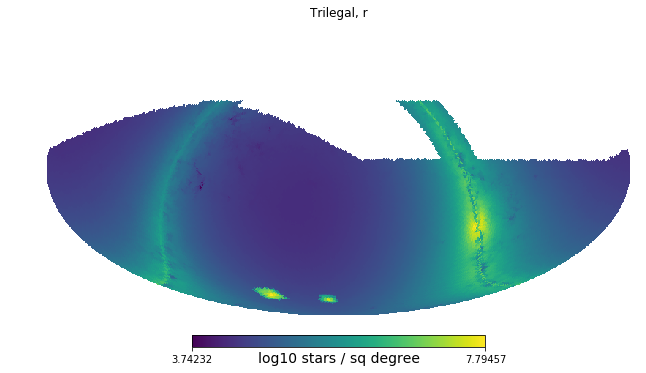

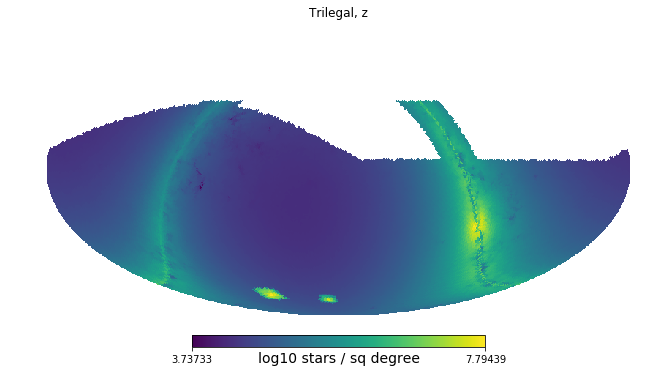

In [6]:
filtername = 'r'

for filtername in 'rz':

    # Let's load up the galfast map
    #data = np.load('/Users/yoachim/git_repos/sims_maps/StarMaps/starDensity_%s_nside_64.npz' % filtername)
    starDensity, bins = tri_rebin(nside=nside, filtername=filtername)
    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    # magnitude bins 
    #bins=temp['starMapBins_%s' % filtername].copy()
    # pixels where there were so many stars some were skipped
    #mask = data['overMaxMask'].copy
    #data.close()
    hp.mollview(np.log10(starDensity[:,-1]), title='Trilegal, %s' % filtername, unit='log10 stars / sq degree')


    mags = [27.6, 27.4,  27., 26.0, 26.2, 24.6, 24.4,  24.]
    indxes = [np.where(np.round(bins[1:]*10) == np.round(rmag*10)) for rmag in mags]

    masks = {'diamond': diamond_map, 'wfd': wfd_map, 'north': north_map, 'south': south_map}
    pix_area = hp.nside2pixarea(nside, degrees=True)


    names = ['%smag' % filtername]
    names.extend(list(masks.keys()))
    types = [float]*len(names)
    result_array = np.zeros(len(mags), dtype=list(zip(names,types)))

    for i,indx in enumerate(indxes):
        for key in masks:
            result_array[i][key] = np.sum(masks[key]*starDensity[:,indx].ravel())*pix_area/1e9
        result_array[i]['%smag' % filtername] = bins[1:][indx]

    df = pd.DataFrame(result_array)
    df['sum'] = df['diamond'] + df['wfd'] + df['north'] + df['south']
    print('billions of stars')
    print(df)

In [7]:
# Double check that we did indeed load up the correct resolution map
#hp.npix2nside(starDensity[:,-1].size) == nside

In [8]:
#bins

In [9]:
# rather than interpolate, let's just show what we got
